Evaluates a FGSM adversarial trained model for epsilon 0.5, where both in-domain and out-domain samples
were transformed to adversarial samples and appended to training datasets.

In [1]:
import sys
sys.path.append('/nfs/homedirs/giri/masterthesis')

In [26]:
import torch
import os
from sklearn.metrics import precision_recall_curve,auc,roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from pylab import rcParams
from PIL import Image
from IPython.display import display
from robust_priornet.eval.uncertainty import UncertaintyMeasuresEnum
from robust_priornet.utils.visualizer import plot_adv_samples,plot_all_roc_curves, plot_all_pr_curves

In [3]:
model_dir="runtime-model-vgg6-50epochs-robust"
batch_size=64
n_in=28
num_channels=1
data_dir="./runtime-data"
in_dataset="MNIST"

### Utils

In [13]:
def display_pr_roc_curves(model_dir, eval_dir, uncertainty_measure: UncertaintyMeasuresEnum):
    #figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_PR_Curve.png'))
    display(img)
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_ROC_Curve.png'))
    display(img)

In [19]:
def create_vis_plots(org_eval_dir, attack_dir, epsilon, plots_dir='vis', misclassified_indices=[], limit=None):
    # all images are saved in 'vis' directory under attack folder
    misclassified_samples = plot_adv_samples(org_eval_dir, attack_dir, epsilon, plots_dir, misclassified_indices, limit=limit)

    last_batch = misclassified_samples - (misclassified_samples%10) if limit is None else (limit-10)
    display(Image.open(f"{attack_dir}/e{epsilon}-attack/{plots_dir}/result_vis_{last_batch}.png")) # prints the last but one batch

## Misclassify detect task (only In domain dataset) evaluation (CPU)
#### For GPU eval, use seml script eval_seml.py

In [4]:
out_dir=model_dir+"/eval"

In [5]:
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --model_dir {model_dir} --result_dir {out_dir} --task misclassification_detect --batch_size {batch_size} {data_dir} {in_dataset} OMNIGLOT"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --model_dir runtime-model-vgg6-50epochs-robust --result_dir runtime-model-vgg6-50epochs-robust/eval --task misclassification_detect --batch_size 64 ./runtime-data MNIST OMNIGLOT


In [6]:
os.system(cmd)

0

#### Evaluation results - CONFIDENCE

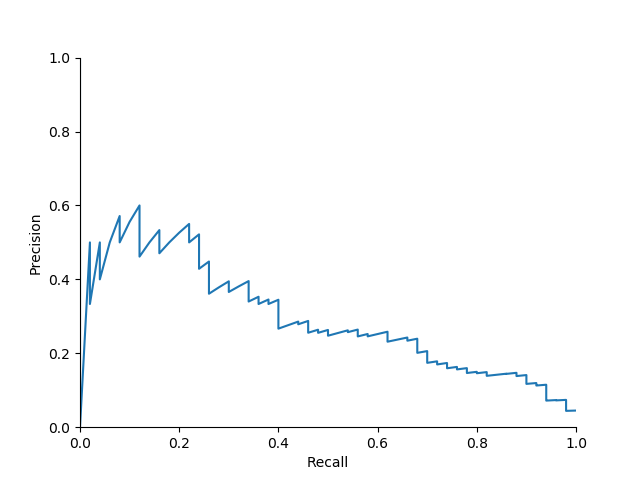

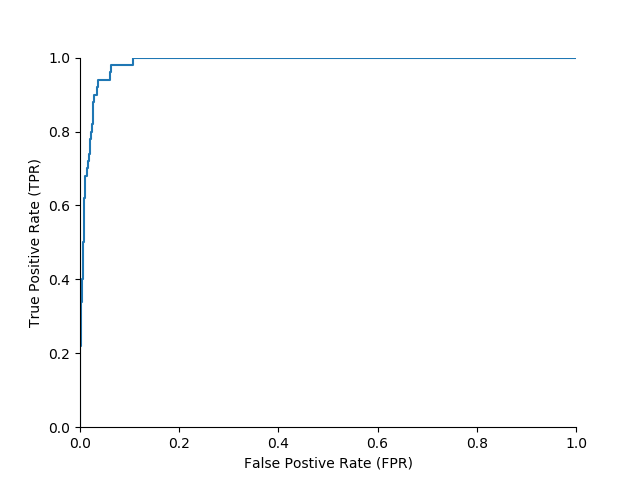

In [14]:
display_pr_roc_curves(model_dir, 'eval', UncertaintyMeasuresEnum.CONFIDENCE)

#### Evaluation results - overall

In [15]:
# Model's evaluation results for misclassification task
with open(f'{model_dir}/eval/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.5 
NLL: 4.051000118255615 
AUPR using confidence: 29.1
AUROC using confidence: 98.6
AUPR using total_uncertainty: 25.4
AUROC using total_uncertainty: 98.5
AUPR using expected_data_uncertainty: 27.5
AUROC using expected_data_uncertainty: 98.6
AUPR using distributional_uncertainty: 21.2
AUROC using distributional_uncertainty: 97.8
AUPR using differential_entropy: 22.4
AUROC using differential_entropy: 98.2



## OOD Detect task (Both In-domain and OOD dataset) evaluation (CPU)
#### For GPU eval, use seml script eval_seml.py

In [10]:
ood_dataset="SVHN"
out_dir=model_dir+"/ood-eval-svhn"

In [11]:
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --model_dir runtime-model-vgg6-50epochs-robust --result_dir runtime-model-vgg6-50epochs-robust/ood-eval-svhn ./runtime-data MNIST SVHN


In [12]:
os.system(cmd)

0

#### Evaluation results - CONFIDENCE

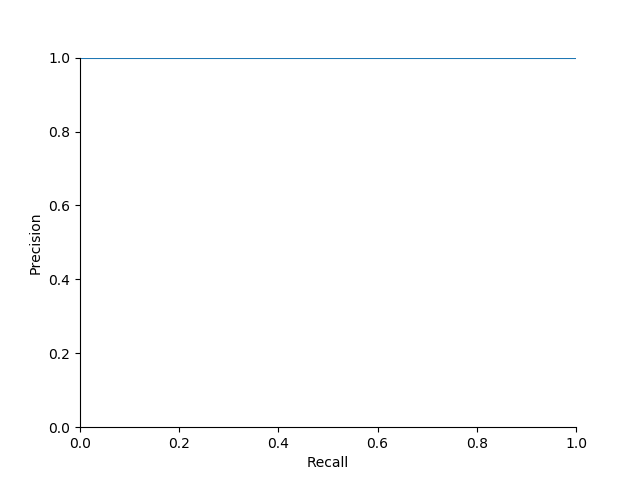

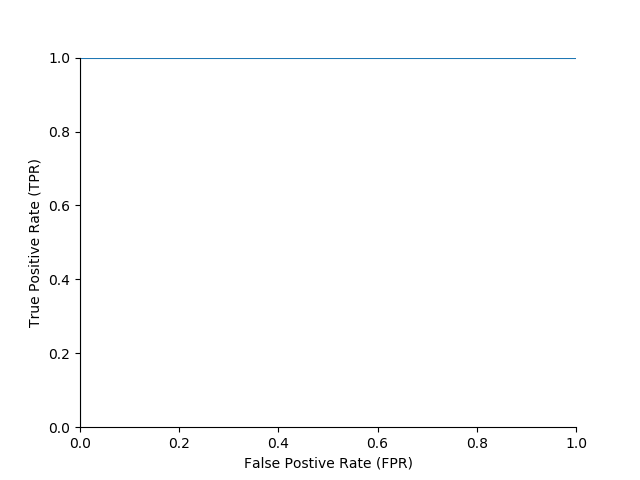

In [16]:
display_pr_roc_curves(model_dir, 'ood-eval', UncertaintyMeasuresEnum.CONFIDENCE)

#### Evaluation results - overall

In [17]:
# VGG6 Model's evaluation results for ood detect task - against OMNIGLOT (ood dataset used in training)
with open(f'{model_dir}/ood-eval/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.5 
NLL: 4.051000118255615 
AUPR using confidence: 100.0
AUROC using confidence: 100.0
AUPR using total_uncertainty: 100.0
AUROC using total_uncertainty: 100.0
AUPR using expected_data_uncertainty: 100.0
AUROC using expected_data_uncertainty: 100.0
AUPR using distributional_uncertainty: 100.0
AUROC using distributional_uncertainty: 100.0
AUPR using differential_entropy: 100.0
AUROC using differential_entropy: 100.0



In [18]:
# VGG6 Model's evaluation results for ood detect task - against SVHN (ood dataset not seen during training)
with open(f'{model_dir}/ood-eval-svhn/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.5 
NLL: 4.051000118255615 
AUPR using confidence: 100.0
AUROC using confidence: 100.0
AUPR using total_uncertainty: 100.0
AUROC using total_uncertainty: 100.0
AUPR using expected_data_uncertainty: 100.0
AUROC using expected_data_uncertainty: 100.0
AUPR using distributional_uncertainty: 100.0
AUROC using distributional_uncertainty: 100.0
AUPR using differential_entropy: 100.0
AUROC using differential_entropy: 100.0



## FGSM Attack on confidence (max probability of predictive posterior)

In [20]:
epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

In [21]:
out_dir = model_dir+"/attack-fgsm"
cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria confidence --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria confidence --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs-robust ./runtime-data MNIST runtime-model-vgg6-50epochs-robust/attack-fgsm


In [22]:
os.system(cmd)

0

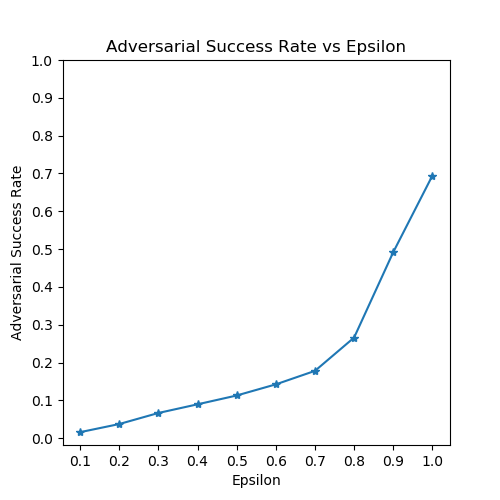

In [23]:
# sample epsilon curve
img = Image.open(os.path.join(model_dir, "attack-fgsm", "epsilon-curve.png"))
display(img)

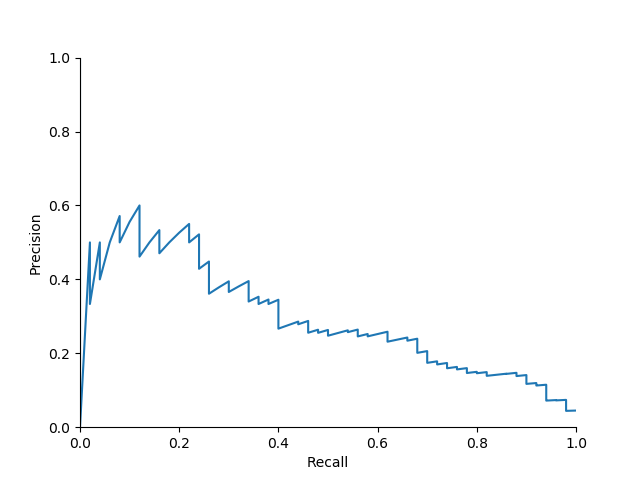

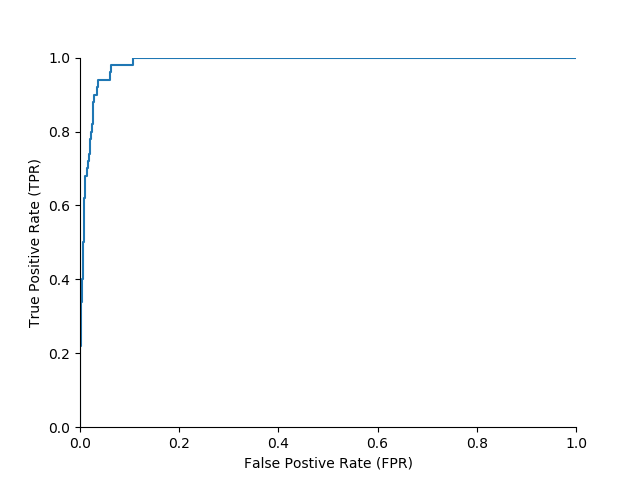

In [24]:
# model before attack
display_pr_roc_curves(model_dir, 'eval', UncertaintyMeasuresEnum.CONFIDENCE)

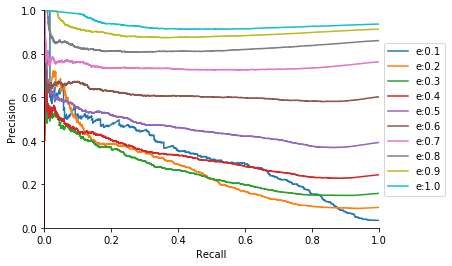

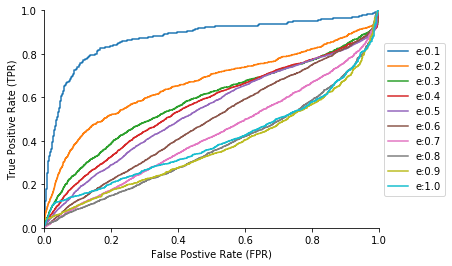

In [29]:
# model under attack (without adv training)
measure = UncertaintyMeasuresEnum.CONFIDENCE
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm', f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm', f"{measure._value_}_ROC_summary.png")))

In [27]:
# model under attack (after adv training)
attack_dir=os.path.join(model_dir, "attack-fgsm")
measure = UncertaintyMeasuresEnum.CONFIDENCE
plot_all_roc_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)

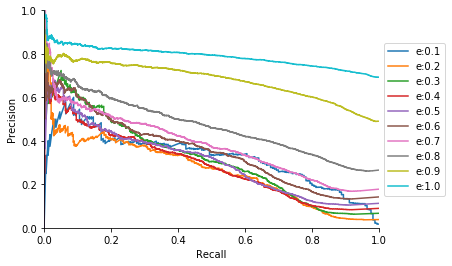

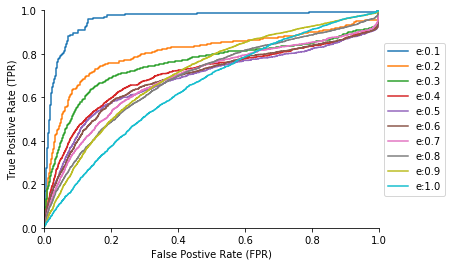

In [28]:
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

# Misclassified samples under attack:  1126
# Correct classified samples prior attack:  9950
# Real adversarial samples under attack:  1122


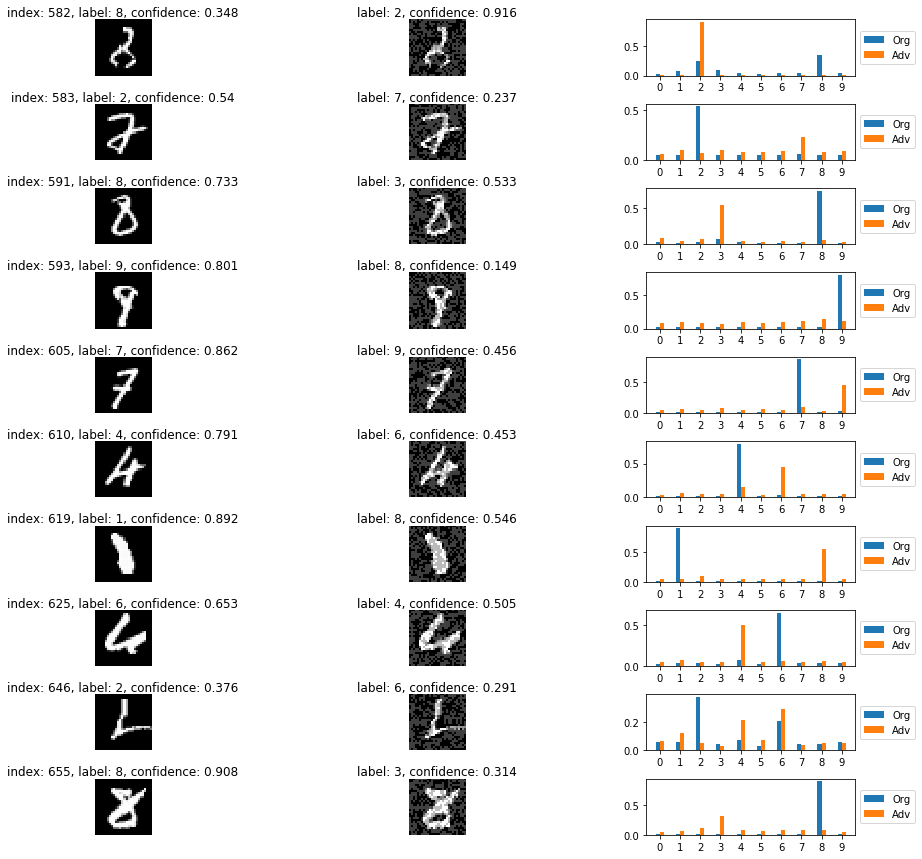

In [30]:
# some adversarial samples
attack_dir=os.path.join(model_dir, "attack-fgsm")
org_eval_dir=os.path.join(model_dir, "eval")
create_vis_plots(org_eval_dir, attack_dir, 0.5, limit=100)